In [0]:
# message passing algorithm inspired by tutorial: http://nghiaho.com/?page_id=1366&fbclid=IwAR0NdLqvHdjwbJ4NxARG1w3vABrofXgijNtq3PUNsPPI0QPjGyBS7V16Nws#implementation
# you have every rights for using this code how you want :)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

In [0]:
#fetching images (e.g. tsukuba images pair)
from google.colab import files
# files.upload()
# files.upload()

In [0]:
imgL = np.array(Image.open('tsukuba-imL.png').convert('L'), dtype=np.int16)
imgR = np.array(Image.open('tsukuba-imR.png').convert('L'), dtype=np.int16)

In [159]:
height,width = imgL.shape
height,width

(288, 384)

In [0]:
labels = 16

In [0]:
# smoothnessCost enforces smooth labeling across adjacent hidden nodes. Function penalizes adjacent labels which are different.
def smoothnessCost(i,j,lmbd=20,K=2):
    return lmbd * np.minimum((i-j)**2,K)

In [0]:
smoothness_matrix = np.fromfunction(smoothnessCost,(labels,labels),dtype=float)

In [0]:
# dataCost returns the cost of assigning label value  of xi to data yi, so we want low cost for good matches and high otherwise.
def dataCost(lab,rad=2):
    strd = np.lib.stride_tricks.as_strided
    brd_slice = slice(labels-rad,-labels+rad)
    sub_shape = (rad*2+1,rad*2+1)
    imgleft = imgL[brd_slice,brd_slice]
    imgright = imgR[brd_slice,labels-rad-lab+1:-labels+rad-lab+1]
    view_shape = tuple(np.subtract(imgleft.shape, sub_shape) + 1) + sub_shape
    sub_imgL = strd(imgleft,view_shape,imgleft.strides*2)
    sub_imgR = strd(imgright,view_shape,imgR.strides*2)
    return np.sum(np.abs(sub_imgL-sub_imgR), axis=(2,3)) / (rad*2+1)**2

In [0]:
dircts = dict(zip(['right','left','up','down','base'], range(5)))

In [0]:
def createMRF(height,width,init_val=0):
    return np.full((height,width,5,labels),fill_value=init_val,dtype=float)

In [0]:
def makeBorder(mrf):
    brd_slice = slice(labels,-labels)
    for i in range(labels):
        mrf[brd_slice,brd_slice,dircts['base'], i] = dataCost(i)

In [0]:
opposite = {'right':dircts['left'],'left':dircts['right'],'up':dircts['down'],'down':dircts['up']}
def dir_coord(x,y,direct):
    if direct == 'up':
        return x,y-1
    elif direct == 'down':
        return x,y+1
    elif direct == 'left':
        return x-1,y
    else:
        return x+1,y

In [0]:
def send_msg(mrf,x,y,direct):
    dir_slice = np.array([dircts[k] for k in (set(dircts.keys()) - {direct})],dtype=int)
    res = smoothness_matrix + mrf[y,x,dir_slice,:].sum(0)
    min_vals = np.minimum(res.min(axis=1),4294967295)
    xi,yi = dir_coord(x,y,direct)
    opo = opposite[direct]
    mrf[yi,xi,opo,:] = min_vals

def message_passing(mrf):
    for y in range(height):
        for x in range(width-1):
            send_msg(mrf,x,y,'right')
    for y in range(height):
        for x in range(width-1,0,-1):
            send_msg(mrf,x,y,'left')
    for x in range(width):
        for y in range(height-1):
            send_msg(mrf,x,y,'down')
    for x in range(width):
        for y in range(height-1,0,-1):
            send_msg(mrf,x,y,'up')

In [0]:
def calculate_energy(mrf):
    best_labels = np.argmin(np.sum(mrf,axis=2),axis=2).reshape(-1)
    energy_parts = mrf[:,:,dircts['base'],:].reshape(-1,labels)[range(np.prod(mrf.shape) // (5*16)),best_labels]
    print('energy:',np.sum(energy_parts))
    
def get_depth_map(mrf,save=False):
    best_labels = np.argmin(np.sum(mrf,axis=2),axis=2)
    res_image = best_labels * (256//labels)
    plt.imshow(res_image)
    plt.show(block=False)
    if save:
        plt.imsave('result_depth_map.jpg',res_image)

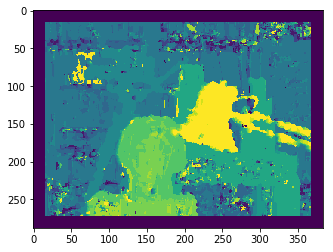

1  energy: 299590.80000000005
2  energy: 298267.64


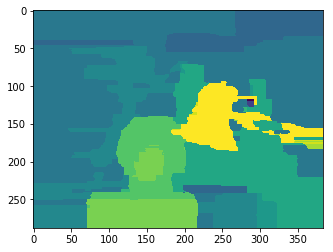

In [171]:
# message passing algorithm. Message passing is ONLY performed on hidden nodes.
mrf = createMRF(height,width)
makeBorder(mrf)
get_depth_map(mrf)

iterations=2
for i in range(iterations):
    message_passing(mrf)
    print(i+1,' ',end='')
    calculate_energy(mrf)
get_depth_map(mrf,save=True)
